<h1>Where to open a brand new CrossFit box in Denver, CO</h1>

<h2>Project Goal</h2>

The goal of this project is to identify the best suitable area where to open a new Crossfit Box in the city of Denver, Colorado. This new activity will comprise a large area dedicated to sport (crossfit with small track for running and bodyweight gymnastic, included changing rooms) plus a recreation and cafe area.

<h2>Denver is officially divided in 78 neighborhoods</h2>

<img src='denver-1.jpg' size=10x30></img>

<h3>Import all the required packages</h3>

In [112]:
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

Solving environment: ...working... done

# All requested packages already installed.



<h3>Neighborhood list imported directly from www.denvergov.org Open Data. Then a bit of data cleaning.</h3>

In [113]:
neigh_csv = 'https://www.denvergov.org/media/gis/DataCatalog/statistical_neighborhoods/csv/statistical_neighborhoods.csv'
Denver_NeighTable = pd.read_csv(neigh_csv)
Denver_NeighTable.drop(['NBHD_ID','TYPOLOGY','NOTES'], axis=1, inplace=True)
Denver_NeighTable.rename(columns={'NBHD_NAME':'Neighborhood'}, inplace=True)
Denver_NeighTable['Neighborhood'] = Denver_NeighTable['Neighborhood'].str.lower()
Denver_NeighTable['Neighborhood'] = Denver_NeighTable['Neighborhood'].str.replace('-','')
Denver_NeighTable.sort_values(by='Neighborhood', inplace=True)
Denver_NeighTable.shape

(78, 1)

Adding latitude-longitude coordinates to the neighborhood table using GEOPY

In [114]:
lat=[]
lon=[]
for i, neigh in enumerate(Denver_NeighTable.Neighborhood):
    address = neigh+', Denver, CO'
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if (location):
        lat.append(location.latitude)
        lon.append(location.longitude)
        print(i+1,"-",address, location.latitude, location.longitude)
    else:
        lat.append(np.nan)
        lon.append(np.nan)
        print(i+1,"-",address)

Denver_NeighTable['Latitude'] = lat
Denver_NeighTable['Longitude'] = lon

1 - athmar park, Denver, CO 39.7036815 -105.01074128924688
2 - auraria, Denver, CO 39.7465219 -105.0067102
3 - baker, Denver, CO 39.711594500000004 -104.99374985708542
4 - barnum, Denver, CO 39.71768305 -105.03245529638046
5 - barnum west, Denver, CO 39.717155149999996 -105.0464972167263
6 - bear valley, Denver, CO 37.5688237 -120.1193489
7 - belcaro, Denver, CO 39.703082 -104.9464724
8 - berkeley, Denver, CO 39.7752306 -105.03926106998205
9 - capitol hill, Denver, CO 39.7358754 -104.9799213
10 - cbd, Denver, CO 9.156225 92.8215167
11 - central park, Denver, CO 39.7706387 -104.8916194
12 - chaffee park, Denver, CO 39.787909 -105.01099347721791
13 - cheesman park, Denver, CO 39.73281355 -104.96645529888413
14 - cherry creek, Denver, CO 39.6834381 -104.900001
15 - city park, Denver, CO 39.74734 -104.95028497370055
16 - city park west, Denver, CO 39.74537615 -104.96657726439688
17 - civic center, Denver, CO 39.738181 -104.9877439
18 - clayton, Denver, CO 39.76675995 -104.9501994027352
19 

Unfortunately GEOPY did not help 100%. Several items not identified (or wrongly identified) by GEOPY need to be fixed.

In [115]:
Denver_NeighTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 22 to 65
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  78 non-null     object 
 1   Latitude      73 non-null     float64
 2   Longitude     73 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.4+ KB


<b>5</b> Denver Neighborhood has not been recognized. Now let's check if we spot any outliers (wrong values) in Lat/Long

In [116]:
Denver_NeighTable.describe()

,Latitude,Longitude
count,73.000000,73.000000
mean,37.939433,-98.049460
std,7.792284,27.068876
min,5.342273,-122.339330
25%,39.683598,-105.015823
50%,39.736379,-104.977986
75%,39.764466,-104.907154
max,48.540285,92.821517


<h3>Outliers detection (due to wrong response from GEOPY)</h3>

> Latitude

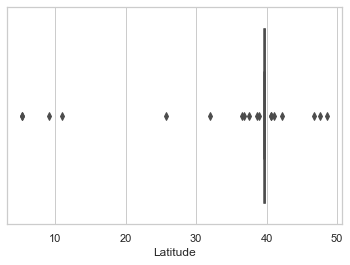

In [117]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=Denver_NeighTable['Latitude'])

We clearly see several outliers with Latitude less than 35°. Let's list them.

In [118]:
filter_wrongLowLAT = Denver_NeighTable['Latitude'] < 39
Denver_NeighTable[filter_wrongLowLAT]

,Neighborhood,Latitude,Longitude
63,bear valley,37.568824,-120.119349
49,cbd,9.156225,92.821517
41,goldsmith,31.980673,-102.615150
40,indian creek,38.914388,-94.340853
36,kennedy,10.950475,-74.806373
10,marston,36.518950,-89.612579
34,overland,38.699027,-90.366095
24,university,5.346628,-72.394457
32,university park,25.746727,-80.368147
64,virginia village,36.799614,-75.995395


We also see few outliers with Latitude greater than 45°. Let's identify and them to the list.

In [119]:
filter_wrongHighLAT = Denver_NeighTable['Latitude'] > 40.5
Denver_NeighTable[filter_wrongHighLAT]

,Neighborhood,Latitude,Longitude
7,country club,40.618963,-105.041214
77,dia,40.623273,-4.024968
11,fort logan,46.678635,-111.173714
37,hampden,48.540285,-98.654290
39,hampden south,42.121959,-72.531945
5,speer,40.988370,-89.650375
12,washington virginia vale,47.627306,-122.339330


In [120]:
Denver_Neigh_tobefixedLowLAT = Denver_NeighTable[filter_wrongLowLAT]
Denver_Neigh_tobefixedHighLAT = Denver_NeighTable[filter_wrongHighLAT]
Denver_Neigh_tobefixedHL_LAT = Denver_Neigh_tobefixedLowLAT.append(Denver_Neigh_tobefixedHighLAT)
Denver_Neigh_tobefixedHL_LAT

,Neighborhood,Latitude,Longitude
63,bear valley,37.568824,-120.119349
49,cbd,9.156225,92.821517
41,goldsmith,31.980673,-102.615150
40,indian creek,38.914388,-94.340853
36,kennedy,10.950475,-74.806373
10,marston,36.518950,-89.612579
34,overland,38.699027,-90.366095
24,university,5.346628,-72.394457
32,university park,25.746727,-80.368147
64,virginia village,36.799614,-75.995395


> Longitude

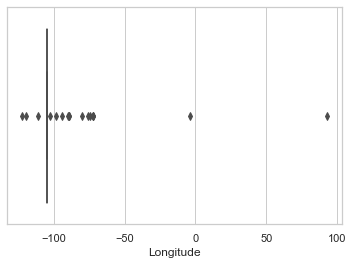

In [121]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=Denver_NeighTable['Longitude'])

There are outliers with Longitude less than -115° and greater than -95°. Let's list them.

In [122]:
filter_wrongLowLON = Denver_NeighTable['Longitude'] < -107
Denver_NeighTable[filter_wrongLowLON]

,Neighborhood,Latitude,Longitude
63,bear valley,37.568824,-120.119349
11,fort logan,46.678635,-111.173714
12,washington virginia vale,47.627306,-122.339330


In [123]:
filter_wrongHighLON = Denver_NeighTable['Longitude'] > -104
Denver_NeighTable[filter_wrongHighLON]

,Neighborhood,Latitude,Longitude
49,cbd,9.156225,92.821517
77,dia,40.623273,-4.024968
41,goldsmith,31.980673,-102.615150
37,hampden,48.540285,-98.654290
39,hampden south,42.121959,-72.531945
40,indian creek,38.914388,-94.340853
36,kennedy,10.950475,-74.806373
10,marston,36.518950,-89.612579
34,overland,38.699027,-90.366095
5,speer,40.988370,-89.650375


In [124]:
Denver_Neigh_tobefixedLowLON = Denver_NeighTable[filter_wrongLowLON]
Denver_Neigh_tobefixedHighLON = Denver_NeighTable[filter_wrongHighLON]
Denver_Neigh_tobefixedHL_LON = Denver_Neigh_tobefixedLowLON.append(Denver_Neigh_tobefixedHighLON)
Denver_Neigh_tobefixedHL_LON

,Neighborhood,Latitude,Longitude
63,bear valley,37.568824,-120.119349
11,fort logan,46.678635,-111.173714
12,washington virginia vale,47.627306,-122.339330
49,cbd,9.156225,92.821517
77,dia,40.623273,-4.024968
41,goldsmith,31.980673,-102.615150
37,hampden,48.540285,-98.654290
39,hampden south,42.121959,-72.531945
40,indian creek,38.914388,-94.340853
36,kennedy,10.950475,-74.806373


> 5 missing values

In [125]:
Filter_na = Denver_NeighTable['Latitude'].isna()
Denver_NeighTable[Denver_NeighTable['Latitude'].isna()]

,Neighborhood,Latitude,Longitude
56,college view south platte,NaN,NaN
1,cory merrill,NaN,NaN
54,gateway green valley ranch,NaN,NaN
53,lowry field,NaN,NaN
67,northeast park hill,NaN,NaN


Finally let's merge all the issues in one dataframe

In [126]:
Denver_Neigh_tobefixedNA = Denver_NeighTable[Filter_na]
Denver_Neigh_tobefixed_NALAT = Denver_Neigh_tobefixedNA.append(Denver_Neigh_tobefixedHL_LAT)
Denver_Neigh_tobefixed = Denver_Neigh_tobefixed_NALAT.append(Denver_Neigh_tobefixedHL_LON)
Denver_Neigh_tobefixed.drop_duplicates(inplace=True)
Denver_Neigh_tobefixed.reset_index(inplace=True, drop=True)
Denver_Neigh_tobefixed

,Neighborhood,Latitude,Longitude
0,college view south platte,NaN,NaN
1,cory merrill,NaN,NaN
2,gateway green valley ranch,NaN,NaN
3,lowry field,NaN,NaN
4,northeast park hill,NaN,NaN
5,bear valley,37.568824,-120.119349
6,cbd,9.156225,92.821517
7,goldsmith,31.980673,-102.615150
8,indian creek,38.914388,-94.340853
9,kennedy,10.950475,-74.806373


All the items in this table need to be fixed manually. Let's start with College View South Platte

In [127]:
# Missing LAT, LON
print(Denver_Neigh_tobefixed[Denver_Neigh_tobefixed['Neighborhood'].str.contains('platte')])

                 Neighborhood  Latitude  Longitude
0  college view  south platte       NaN        NaN


<img src='denver-loc-3.jpg' size=10x30></img>

In [128]:
list_0 = [39.673505, -105.002457] # college view south platte

Let's do the same with all the other cells, creating a brand new DataFrame containing all the <b>23</b> Neighborhoods with the correct values

In [129]:
list_1  = [39.691295, -104.948081] # cory merrill
list_2  = [39.777641, -104.768168] # gateway green valley ranch
list_3  = [39.719899, -104.890713] # lowry field
list_4  = [39.773713, -104.921510] # northeast park hill
list_5  = [39.661051, -105.066702] # bear valley
list_6  = [39.744719, -104.993992] # cbd central business district
list_7  = [39.674330, -104.912362] # goldsmith
list_8  = [39.685214, -104.897291] # indian creek
list_9  = [39.652758, -104.863594] # kennedy
list_10 = [39.631498, -105.087529] # marston
list_11 = [39.680652, -104.992633] # overland
list_12 = [39.675748, -104.966794] # university
list_13 = [39.676203, -104.950869] # university park
list_14 = [39.687050, -104.924913] # virginia village
list_15 = [39.703126, -104.979274] # washington park west
list_16 = [39.719871, -104.965764] # country club
list_17 = [39.847059, -104.673331] # dia denver international airport
list_18 = [39.642616, -105.042721] # fort logan
list_19 = [39.659860, -104.894660] # hampden
list_20 = [39.645465, -104.895659] # hampden south
list_21 = [39.719682, -104.979521] # speer
list_22 = [39.702857, -104.912851] # washington virginia vale

In [130]:
DF_array = np.array([list_0, list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9, list_10, list_11, list_12, list_13, list_14, list_15, list_16, list_17, list_18, list_19, list_20, list_21, list_22])
NewCoord = pd.DataFrame(DF_array, columns=['Latitude','Longitude'])
Denver_Neigh_tobefixed.drop(['Latitude','Longitude'], axis=1, inplace=True)
Denver_NeighFixed = Denver_Neigh_tobefixed
Denver_NeighFixed['Latitude'] = NewCoord['Latitude']
Denver_NeighFixed['Longitude'] = NewCoord['Longitude']
Denver_NeighFixed

,Neighborhood,Latitude,Longitude
0,college view south platte,39.673505,-105.002457
1,cory merrill,39.691295,-104.948081
2,gateway green valley ranch,39.777641,-104.768168
3,lowry field,39.719899,-104.890713
4,northeast park hill,39.773713,-104.921510
5,bear valley,39.661051,-105.066702
6,cbd,39.744719,-104.993992
7,goldsmith,39.674330,-104.912362
8,indian creek,39.685214,-104.897291
9,kennedy,39.652758,-104.863594


In [131]:
Denver_Neigh_tobefixed.drop(['Latitude','Longitude'], axis=1, inplace=True)
Denver_NeighFixed = Denver_Neigh_tobefixed
Denver_NeighFixed['Latitude'] = NewCoord['Latitude']
Denver_NeighFixed['Longitude'] = NewCoord['Longitude']
Denver_NeighFixed

,Neighborhood,Latitude,Longitude
0,college view south platte,39.673505,-105.002457
1,cory merrill,39.691295,-104.948081
2,gateway green valley ranch,39.777641,-104.768168
3,lowry field,39.719899,-104.890713
4,northeast park hill,39.773713,-104.921510
5,bear valley,39.661051,-105.066702
6,cbd,39.744719,-104.993992
7,goldsmith,39.674330,-104.912362
8,indian creek,39.685214,-104.897291
9,kennedy,39.652758,-104.863594


Wrong lines get removed from the original table and replaced with the new ones

In [132]:
Denver_NeighTable.drop(Denver_NeighTable[Filter_na].index,axis=0, inplace=True)
Denver_NeighTable.drop(Denver_NeighTable[filter_wrongLowLON].index,axis=0, inplace=True)
Denver_NeighTable.drop(Denver_NeighTable[filter_wrongHighLON].index,axis=0, inplace=True)
Denver_NeighTable.drop(Denver_NeighTable[filter_wrongLowLAT].index,axis=0, inplace=True)
Denver_NeighTable.drop(Denver_NeighTable[filter_wrongHighLAT].index,axis=0, inplace=True)
Denver_NeighTable.shape

<ipython-input-132-fe1b361596b6>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Denver_NeighTable.drop(Denver_NeighTable[filter_wrongLowLON].index,axis=0, inplace=True)
<ipython-input-132-fe1b361596b6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Denver_NeighTable.drop(Denver_NeighTable[filter_wrongHighLON].index,axis=0, inplace=True)
<ipython-input-132-fe1b361596b6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Denver_NeighTable.drop(Denver_NeighTable[filter_wrongLowLAT].index,axis=0, inplace=True)
<ipython-input-132-fe1b361596b6>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Denver_NeighTable.drop(Denver_NeighTable[filter_wrongHighLAT].index,axis=0, inplace=True)


(55, 3)

In [133]:
Denver_Neigh = Denver_NeighTable.append(Denver_NeighFixed, ignore_index=True)
Denver_Neigh.sort_values(by='Neighborhood', ascending=True, inplace=True)
Denver_Neigh.reset_index(drop=True, inplace=True)

Let's check again Lat and Lon distribution (box plot)

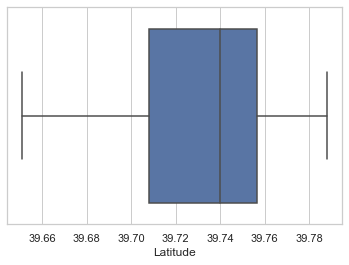

In [134]:
ax = sns.boxplot(x=Denver_NeighTable['Latitude'])

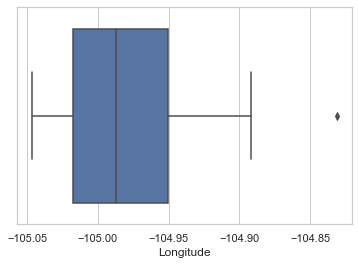

In [135]:
ax = sns.boxplot(x=Denver_NeighTable['Longitude'])

Few outliers stil present for Longitude; let's see them

In [136]:
Denver_Neigh[Denver_Neigh['Longitude']>-104.85]

,Neighborhood,Latitude,Longitude
23,dia,39.847059,-104.673331
28,gateway green valley ranch,39.777641,-104.768168
45,montbello,39.784223,-104.831154


They are correct! Finally we have a <u>clean</u> table for Denver Neighboorhood.

In [137]:
Denver_Neigh.head()

,Neighborhood,Latitude,Longitude
0,athmar park,39.703682,-105.010741
1,auraria,39.746522,-105.006710
2,baker,39.711595,-104.993750
3,barnum,39.717683,-105.032455
4,barnum west,39.717155,-105.046497


Now we can draw the city map with all the neighborhood points correctly allocated on it

In [138]:
den_latitude = 39.74
den_longitude = -104.96
NeighNum = len(Denver_Neigh)
map_neigh = folium.Map(location=[den_latitude, den_longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(NeighNum)
ys = [i + x + (i*x)**2 for i in range(NeighNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, neigh in zip(Denver_Neigh['Latitude'], Denver_Neigh['Longitude'], Denver_Neigh['Neighborhood']):
    label = folium.Popup(' Neighborhood: ' + neigh + str(lat) + str(lon), parse_html=True)
    neigh_list = Denver_Neigh[Denver_Neigh['Neighborhood'] == neigh].index.item()
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[neigh_list],
        fill=True,
        fill_color=rainbow[neigh_list],
        fill_opacity=0.7).add_to(map_neigh)

map_neigh

<h2>Neighborhood Venues analysis using Foursquare API</h2>
<h3>data fetch and elaboration</h3>

In [139]:
CLIENT_ID = '1WVVBRB2ZEYXNYPADNZXC0WDY0DDYGLAA1WOXISHYGFA2AGZ' # your Foursquare ID
CLIENT_SECRET = 'XJK1TYT0SSS0SEFOO2N5NLSBFTEUZEDCY2DUQMAQK32VFH0L' # your Foursquare Secret
VERSION = '20201211' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

<h4>Nearby Locations function: for each Neighborhood passed as input all the venues in the 500m radius (default) are saved in a dataframe provided as output</h4>

In [140]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

denver_venues = getNearbyVenues(Denver_Neigh['Neighborhood'], Denver_Neigh['Latitude'], Denver_Neigh['Longitude'])

Now let's filter all the already existing venues in the same category i.e. "Gym", "Gym / Fitness Center", "Gym Pool"

In [52]:
denver_gym = denver_venues[denver_venues['Venue Category'].str.contains('Gym')].reset_index(drop=True)
denver_sportvenues = denver_gym

Let's isolate also the swimming pool ("Pool" category)

In [142]:
denver_pool = denver_venues[denver_venues['Venue Category'] == 'Pool'].reset_index(drop=True)
denver_pool

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,bear valley,39.661051,-105.066702,Bear Creek Swim And Tennis Club,39.658394,-105.071022,Pool


Now we have the full Denver Sport Venues list

In [144]:
denver_sportvenues = denver_sportvenues.append(denver_pool)
NeighNum = len(denver_sportvenues['Neighborhood'])
denver_summarysportvenues = denver_sportvenues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude']).reset_index()
denver_summarysportvenues

,Neighborhood,Venue Category
0,union station,5
1,civic center,3
2,university hills,2
3,highland,2
4,bear valley,2
5,north capitol hill,2
6,auraria,1
7,northeast park hill,1
8,washington park,1
9,virginia village,1


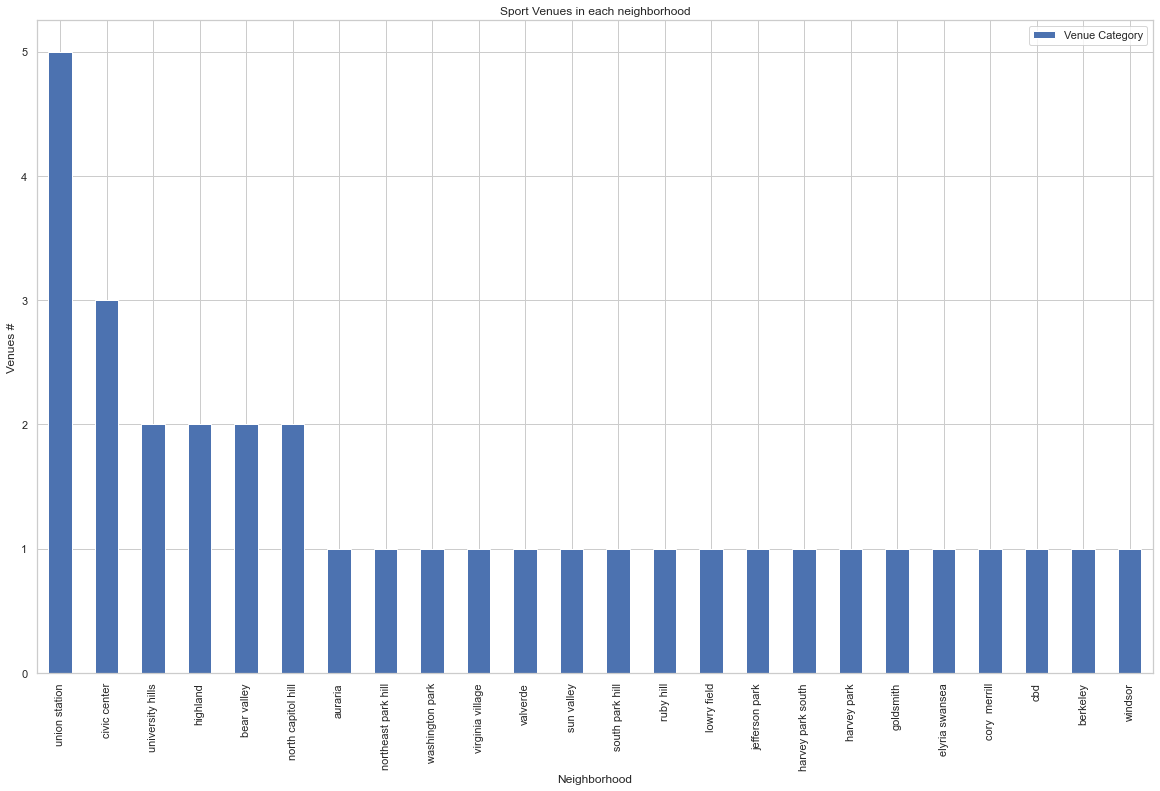

In [145]:
denver_summarysportvenues.plot(kind='bar', x='Neighborhood', y='Venue Category', figsize=(20, 12), rot=90) ## rotate the xticks(labelled points on x-axis) by 90 degrees
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Venues #') # add y-label to the plot
plt.title('Sport Venues in each neighborhood') # add title to the plot
plt.show()

Let's view on the map each Sport venues in Denver(color aggregated by Neighborhood). It's clear that most of the venues are located in the city center.

In [146]:
den_latitude = 39.74
den_longitude = -104.96
map_sport = folium.Map(location=[den_latitude, den_longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(NeighNum)
ys = [i + x + (i*x)**2 for i in range(NeighNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, poi, neigh in zip(denver_sportvenues['Venue Latitude'], denver_sportvenues['Venue Longitude'], denver_sportvenues['Venue'], denver_sportvenues['Neighborhood']):
    label = folium.Popup(str(poi) + ' - ' + neigh, parse_html=True)
    neigh_list = denver_summarysportvenues[denver_summarysportvenues['Neighborhood'] == neigh].index.item()
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[neigh_list],
        fill=True,
        fill_color=rainbow[neigh_list],
        fill_opacity=0.7).add_to(map_sport)

map_sport

<h4>Going into details on the venue analysis</h4>

Venue categories

In [147]:
print(denver_venues.groupby('Neighborhood').count()['Venue'])
print('\nThere are {} uniques categories.'.format(len(denver_venues['Venue Category'].unique())))

Neighborhood
athmar park        2
auraria           22
baker              7
barnum             7
barnum west        2
                ... 
west colfax       22
west highland     26
westwood           3
whittier           5
windsor          100
Name: Venue, Length: 77, dtype: int64

There are 247 uniques categories.


Venues by neighborhood (100 is the max limit for each neighborhood from the Foursquare Data Fetch)

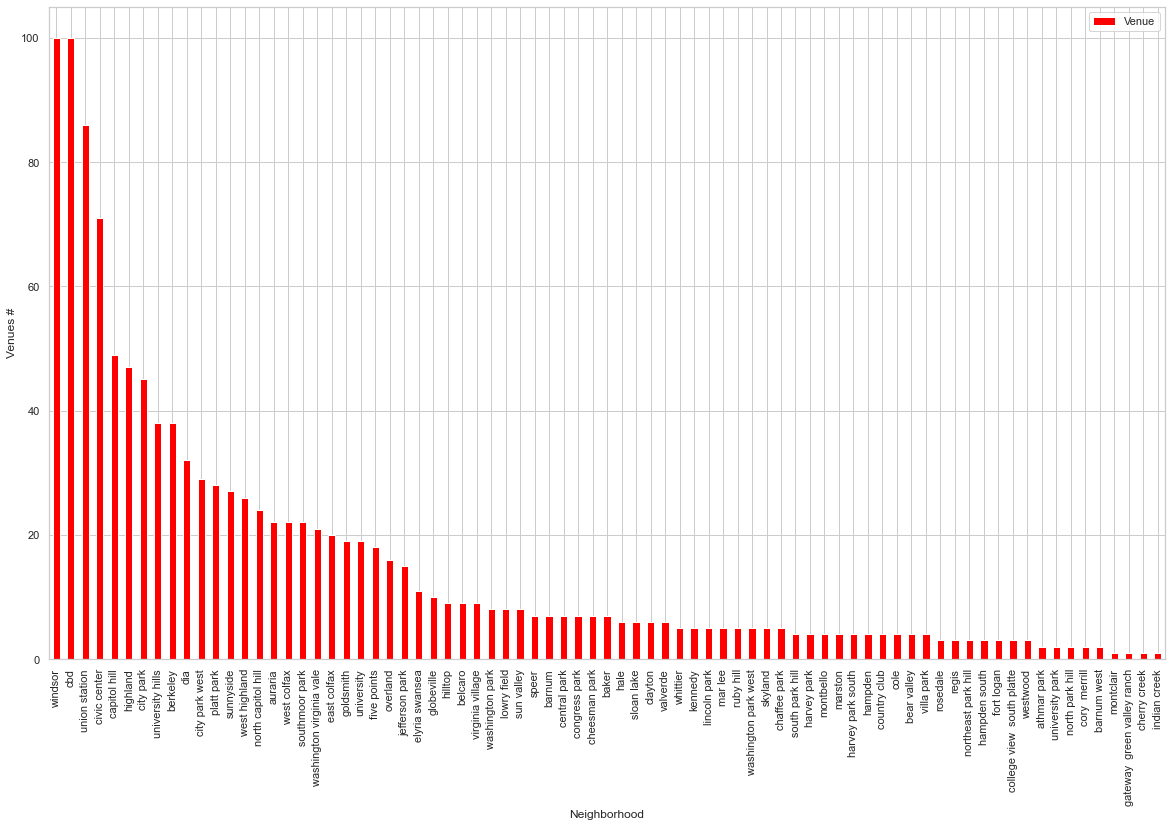

In [148]:
denver_biggerneighlist = denver_venues.groupby('Neighborhood').count().drop(columns=['Neighborhood Latitude','Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category']).reset_index()
denver_biggerneighlist.sort_values(by=['Venue'], inplace=True, ascending=False)
denver_biggerneighlist.plot(kind='bar', x='Neighborhood', y='Venue', figsize=(20, 12), rot=90, color='red') ## rotate the xticks(labelled points on x-axis) by 90 degrees
plt.xlabel('Neighborhood')
plt.ylabel('Venues #')
plt.show()

From the chart we see that only a small subset of neighborhood shows more than 10 different venues (27 precisely)

In [149]:
denver_biggerneigh = denver_biggerneighlist[denver_biggerneighlist['Venue']>=10]
denver_biggerneigh.shape

(27, 2)

<h4>Encode "Venue Category" feature with Pandas get_dummies method</h4>

In [150]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = denver_venues['Neighborhood'] 
# move neighborhood column to the first column
cols = list(denver_onehot.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Neighborhood')) #Remove Neighborhood from list
denver_onehot = denver_onehot[['Neighborhood']+cols] #Create new dataframe with columns in the order you want
denver_onehot

,Neighborhood,ATM,Accessories Store,Airport,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,athmar park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,athmar park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,auraria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,auraria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,auraria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,windsor,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1183,windsor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1184,windsor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1185,windsor,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4>For each neighborhood let's list the top 3 venues categories most present</h4>

In [151]:
denver_grouped = denver_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 3
for hood in denver_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = denver_grouped[denver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue Category','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----athmar park----
              Venue Category  Freq
0  Cajun / Creole Restaurant   0.5
1                       Park   0.5
2                        ATM   0.0


----auraria----
       Venue Category  Freq
0          Sports Bar  0.14
1  Basketball Stadium  0.09
2         Coffee Shop  0.09


----baker----
                             Venue Category  Freq
0                      Marijuana Dispensary  0.14
1                        Chinese Restaurant  0.14
2  Residential Building (Apartment / Condo)  0.14


----barnum----
               Venue Category  Freq
0  Construction & Landscaping  0.29
1           Convenience Store  0.14
2                  Hookah Bar  0.14


----barnum west----
      Venue Category  Freq
0  Electronics Store   0.5
1       Home Service   0.5
2                ATM   0.0


----bear valley----
  Venue Category  Freq
0           Park  0.50
1      Cafeteria  0.25
2           Pool  0.25


----belcaro----
                  Venue Category  Freq
0               Sushi Restaurant

2   Mexican Restaurant  0.06


----university----
   Venue Category  Freq
0  Breakfast Spot  0.11
1     Coffee Shop  0.11
2            Café  0.11


----university hills----
           Venue Category  Freq
0                    Bank  0.05
1  Furniture / Home Store  0.05
2           Grocery Store  0.05


----university park----
   Venue Category  Freq
0            Park   0.5
1  Cosmetics Shop   0.5
2             ATM   0.0


----valverde----
         Venue Category  Freq
0         Indie Theater  0.17
1  Gym / Fitness Center  0.17
2               Brewery  0.17


----villa park----
       Venue Category  Freq
0  Light Rail Station  0.25
1                Park  0.25
2   Food & Drink Shop  0.25


----virginia village----
      Venue Category  Freq
0        Coffee Shop  0.22
1  Convenience Store  0.11
2                Gym  0.11


----washington park----
  Venue Category  Freq
0           Park  0.25
1     Bike Trail  0.12
2   Tennis Court  0.12


----washington park west----
   Venue Category  Fr

<h4>For each neighborhood the top most occurring venue categories are saved and sorted by frequency</h4>

In [152]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = denver_grouped['Neighborhood']
for ind in np.arange(denver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(denver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,athmar park,Park,Cajun / Creole Restaurant,Dog Run,Food & Drink Shop,Food
1,auraria,Sports Bar,Basketball Stadium,Coffee Shop,Sporting Goods Shop,Theater
2,baker,Distillery,Paper / Office Supplies Store,Residential Building (Apartment / Condo),Whisky Bar,Intersection
3,barnum,Construction & Landscaping,Convenience Store,Food,Insurance Office,Hookah Bar
4,barnum west,Home Service,Electronics Store,Zoo Exhibit,Donut Shop,Food Service
...,...,...,...,...,...,...
72,west colfax,Ice Cream Shop,Pizza Place,Liquor Store,Mexican Restaurant,Coffee Shop
73,west highland,Pizza Place,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Gift Shop
74,westwood,Restaurant,Mexican Restaurant,Marijuana Dispensary,Zoo Exhibit,Electronics Store
75,whittier,Baseball Field,Bar,Café,Dog Run,Park


<h2>K-Means clustering</h2>

First we exclude all the neighborhoods showing already a Gym/Fitness locations

In [153]:
X = denver_grouped
neighborhoods_venues_sorted_clean = neighborhoods_venues_sorted
for neigh in denver_summarysportvenues['Neighborhood']:
    X.drop(X[X['Neighborhood'] == neigh].index, inplace=True)
    neighborhoods_venues_sorted_clean.drop(neighborhoods_venues_sorted_clean[neighborhoods_venues_sorted_clean['Neighborhood'] == neigh].index, inplace=True)
X_ut = X

 We aggregate all the remaining venues into 5 clusters

In [154]:
# set number of clusters
kclusters = 5
denver_grouped_clustering = X_ut.drop('Neighborhood', 1)
X = denver_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
# add clustering labels
neighborhoods_venues_sorted_clean.insert(0, 'Cluster Labels', kmeans.labels_)
denver_merged = Denver_Neigh
denver_merged = denver_merged.join(neighborhoods_venues_sorted_clean.set_index('Neighborhood'), on='Neighborhood', how='right')
denver_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,athmar park,39.703682,-105.010741,0,Park,Cajun / Creole Restaurant,Dog Run,Food & Drink Shop,Food
2,baker,39.711595,-104.993750,3,Distillery,Paper / Office Supplies Store,Residential Building (Apartment / Condo),Whisky Bar,Intersection
3,barnum,39.717683,-105.032455,3,Construction & Landscaping,Convenience Store,Food,Insurance Office,Hookah Bar
4,barnum west,39.717155,-105.046497,4,Home Service,Electronics Store,Zoo Exhibit,Donut Shop,Food Service
6,belcaro,39.703082,-104.946472,3,Fast Food Restaurant,Grocery Store,Wine Shop,Furniture / Home Store,Bakery


Let's see on the map all the neighborhoods in their respective cluster

In [155]:
map_clusters = folium.Map(location=[den_latitude, den_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_merged['Latitude'], denver_merged['Longitude'], denver_merged['Neighborhood'], denver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

In [76]:
map_clusters

<h4>Denver Venues cluster 1 detailed list: <u>Residential</u></h4>

In [77]:
denver_merged.loc[denver_merged['Cluster Labels'] == 0, denver_merged.columns[[0] + list(range(4, denver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
44,marston,Residential Building (Apartment / Condo),Arts & Crafts Store,Warehouse Store,American Restaurant,Zoo Exhibit


<h4>Denver Venues cluster 2 detailed list: <u>Parks, Gardens, Zoo</u></h4>

In [78]:
denver_merged.loc[denver_merged['Cluster Labels'] == 1, denver_merged.columns[[0] + list(range(4, denver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,athmar park,Park,Cajun / Creole Restaurant,Dog Run,Food & Drink Shop,Food
5,bear valley,Park,Cafeteria,Pool,Donut Shop,Food & Drink Shop
11,chaffee park,Park,Convenience Store,Bar,Pharmacy,Electronics Store
19,college view south platte,Brewery,Bakery,Park,Zoo Exhibit,Electronics Store
33,hampden south,Paintball Field,Garden,Park,Zoo Exhibit,Food
53,rosedale,Park,Golf Course,American Restaurant,Zoo Exhibit,Farmers Market
59,speer,Park,Cosmetics Shop,Breakfast Spot,Massage Studio,Assisted Living
65,university park,Cosmetics Shop,Park,Zoo Exhibit,Donut Shop,Food & Drink Shop


<h4>Denver Venues cluster 3 detailed list: <u>Recreation, Food, Restaurants, Shops</u></h4>

In [79]:
denver_merged.loc[denver_merged['Cluster Labels'] == 2, denver_merged.columns[[0] + list(range(4, denver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,baker,Distillery,Paper / Office Supplies Store,Residential Building (Apartment / Condo),Whisky Bar,Intersection
3,barnum,Construction & Landscaping,Convenience Store,Food,Insurance Office,Hookah Bar
4,barnum west,Home Service,Electronics Store,Zoo Exhibit,Donut Shop,Food Service
6,belcaro,Fast Food Restaurant,Grocery Store,Wine Shop,Furniture / Home Store,Bakery
8,capitol hill,Sandwich Place,Pizza Place,Pub,Yoga Studio,Convenience Store
10,central park,Bus Station,Video Store,Light Rail Station,Bakery,Grocery Store
12,cheesman park,Garden,Sports Club,Park,Café,Sculpture Garden
14,city park,Zoo Exhibit,American Restaurant,Exhibit,Gift Shop,Lake
15,city park west,Brewery,American Restaurant,Pharmacy,Mexican Restaurant,Thai Restaurant
17,clayton,Mexican Restaurant,Market,Liquor Store,Park,Discount Store


<h4>Denver Venues cluster 4 detailed list: <u>Business</u></h4>

In [80]:
denver_merged.loc[denver_merged['Cluster Labels'] == 3, denver_merged.columns[[0] + list(range(4, denver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
28,gateway green valley ranch,Business Service,Zoo Exhibit,Electronics Store,Food Service,Food & Drink Shop


<h4>Denver Venues cluster 5 detailed list: <u>Parks, Zoo, Food</u></h4>

In [81]:
denver_merged.loc[denver_merged['Cluster Labels'] == 4, denver_merged.columns[[0] + list(range(4, denver_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,cherry creek,Park,Zoo Exhibit,Donut Shop,Food & Drink Shop,Food
38,indian creek,Park,Zoo Exhibit,Donut Shop,Food & Drink Shop,Food
46,montclair,Park,Zoo Exhibit,Donut Shop,Food & Drink Shop,Food


Clusters 1, 4 and 5 shall be discarded because very small and mainly residential and business focused.
<u>The area we are looking for shall be located therefore in cluster <b>2</b> or <b>3</b>.</u>

<h2>Crime dataset</h2>

Load crime dataset from www.denvergov.org (very huge, takes few minutes)

In [162]:
crime_url = 'https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv'
denver_crimes_dataset = pd.read_csv(crime_url)
denver_crimes_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536287 entries, 0 to 536286
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   INCIDENT_ID             536287 non-null  int64  
 1   OFFENSE_ID              536287 non-null  int64  
 2   OFFENSE_CODE            536287 non-null  int64  
 3   OFFENSE_CODE_EXTENSION  536287 non-null  int64  
 4   OFFENSE_TYPE_ID         536287 non-null  object 
 5   OFFENSE_CATEGORY_ID     536287 non-null  object 
 6   FIRST_OCCURRENCE_DATE   536287 non-null  object 
 7   LAST_OCCURRENCE_DATE    177941 non-null  object 
 8   REPORTED_DATE           536287 non-null  object 
 9   INCIDENT_ADDRESS        487018 non-null  object 
 10  GEO_X                   531698 non-null  float64
 11  GEO_Y                   531698 non-null  float64
 12  GEO_LON                 531697 non-null  float64
 13  GEO_LAT                 531697 non-null  float64
 14  DISTRICT_ID         

In [172]:
denver_crimes_dataset.describe(include='all')

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
count,5.362870e+05,5.362870e+05,536287.000000,536287.000000,536287,536287,536287,177941,536287,487018,5.316980e+05,5.316980e+05,5.316970e+05,531697.000000,536286.000000,536286.000000,536286,536287.000000,536287.000000
unique,NaN,NaN,NaN,NaN,200,15,357564,128814,452279,101988,NaN,NaN,NaN,NaN,NaN,NaN,79,NaN,NaN
top,NaN,NaN,NaN,NaN,traffic-accident,traffic-accident,1/1/2017 12:00:00 AM,5/29/2020 7:00:00 AM,6/1/2020 12:30:00 AM,1499 N BROADWAY ST,NaN,NaN,NaN,NaN,NaN,NaN,five-points,NaN,NaN
freq,NaN,NaN,NaN,NaN,91601,133307,23,18,20,1899,NaN,NaN,NaN,NaN,NaN,NaN,28949,NaN,NaN
mean,4.108799e+09,4.108799e+15,3743.414409,0.205989,NaN,NaN,NaN,NaN,NaN,NaN,3.164824e+06,1.695712e+06,-1.049243e+02,39.718530,3.517837,369.334929,NaN,0.751426,0.249145
std,1.357800e+10,1.357800e+16,1651.084364,0.578363,NaN,NaN,NaN,NaN,NaN,NaN,7.111556e+05,2.245142e+05,1.985121e+00,0.751779,1.778846,178.675651,NaN,0.432187,0.432518
min,2.019600e+04,2.019652e+10,902.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,-1.154641e+02,0.000000,1.000000,111.000000,NaN,0.000000,0.000000
25%,2.016171e+09,2.016171e+15,2305.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.138728e+06,1.683146e+06,-1.050065e+02,39.707726,2.000000,221.000000,NaN,1.000000,0.000000
50%,2.017824e+09,2.017824e+15,3530.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.145655e+06,1.694791e+06,-1.049821e+02,39.739802,3.000000,323.000000,NaN,1.000000,0.000000
75%,2.019684e+09,2.019684e+15,5441.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.162548e+06,1.701886e+06,-1.049223e+02,39.759304,5.000000,521.000000,NaN,1.000000,0.000000


Remove unused columns

In [178]:
denver_crimes_clean = denver_crimes_dataset.drop(columns=['INCIDENT_ID','OFFENSE_ID','FIRST_OCCURRENCE_DATE', 'LAST_OCCURRENCE_DATE', 'GEO_X', 'GEO_Y', 'PRECINCT_ID', 'INCIDENT_ADDRESS', 'OFFENSE_CODE_EXTENSION'])

Consider only crimes (no car accidents)

In [179]:
denver_crimes_only = denver_crimes_clean[denver_crimes_clean['IS_CRIME'] == 1]
denver_crimes_only['OFFENSE_TYPE_ID'].value_counts()

theft-of-motor-vehicle      32739
theft-items-from-vehicle    32300
traf-other                  30742
theft-other                 22064
criminal-trespassing        17315
                            ...  
theft-from-yards                1
riot-incite                     1
drug-barbiturate-mfr            1
theft-of-cable-services         1
money-laundering                1
Name: OFFENSE_TYPE_ID, Length: 197, dtype: int64

Further data clean-up (removing unused columns, extracting year from reported date, sorting by Neighborhood)

In [180]:
denver_crimes_only.drop(columns=['IS_CRIME', 'IS_TRAFFIC', 'OFFENSE_CODE', 'OFFENSE_TYPE_ID'], inplace=True)
denver_crimes_only['REPORTED_DATE'] = denver_crimes_only['REPORTED_DATE'].astype('datetime64[ns]')
denver_crimes_only['YEAR'] = denver_crimes_only['REPORTED_DATE'].dt.year
denver_crimes_only.drop(columns=['REPORTED_DATE'],inplace=True)
denver_crimes_only.sort_values(by='NEIGHBORHOOD_ID', inplace=True)

C:\Users\Gr-user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-180-1504affbd723>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denver_crimes_only['REPORTED_DATE'] = denver_crimes_only['REPORTED_DATE'].astype('datetime64[ns]')
<ipython-input-180-1504affbd723>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [181]:
Denver_Crimes = denver_crimes_only.groupby(['NEIGHBORHOOD_ID']).count().reset_index()
Denver_Crimes.drop(columns=['OFFENSE_CATEGORY_ID', 'GEO_LON', 'GEO_LAT', 'DISTRICT_ID'], inplace=True)
Denver_Crimes.rename(columns={'YEAR':'Crimes'}, inplace=True)
Denver_Crimes['Neighborhood'] = Denver_Crimes['NEIGHBORHOOD_ID'].str.replace('-',' ')
Denver_Crimes.drop(columns=['NEIGHBORHOOD_ID'], inplace=True)
Denver_Crimes

,Crimes,Neighborhood
0,5642,athmar park
1,3764,auraria
2,7662,baker
3,4490,barnum
4,2471,barnum west
...,...,...
74,9420,west colfax
75,3686,west highland
76,9800,westwood
77,2649,whittier


Tables JOIN to integrate the coordinates to the crimes #

In [182]:
Denver_Crimes['UnKey'] = Denver_Crimes['Neighborhood'].str.replace(' ','')
Denver_Neigh['UnKey'] = Denver_Neigh['Neighborhood'].str.replace(' ','')
DenverCrimesSummary = Denver_Neigh.merge(Denver_Crimes, on='UnKey', how='inner')
DenverCrimesSummary.drop(columns=['UnKey', 'Neighborhood_y'], inplace=True)
DenverCrimesSummary.rename(columns={'Neighborhood_x':'Neighborhood'}, inplace=True)
DenverCrimesSummary

,Neighborhood,Latitude,Longitude,Crimes
0,athmar park,39.703682,-105.010741,5642
1,auraria,39.746522,-105.006710,3764
2,baker,39.711595,-104.993750,7662
3,barnum,39.717683,-105.032455,4490
4,barnum west,39.717155,-105.046497,2471
...,...,...,...,...
73,west colfax,39.740093,-105.039202,9420
74,west highland,39.764466,-105.039271,3686
75,westwood,39.704193,-105.039174,9800
76,whittier,39.756363,-104.966558,2649


Consider the top 10 neighboorhood for Crimes# on a bar chart

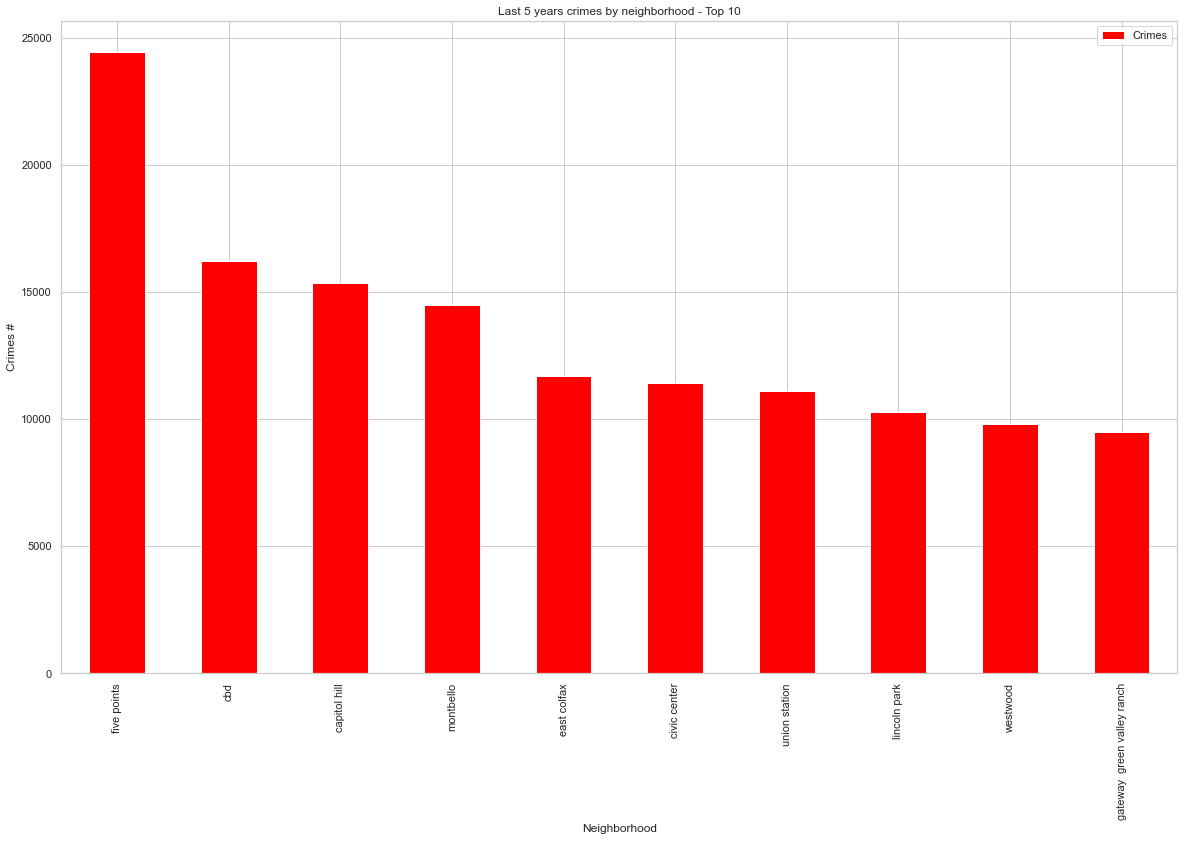

In [184]:
DenverCrimesTop10 = DenverCrimesSummary.sort_values(by=['Crimes'], ascending=False).head(10)
DenverCrimesTop10.plot(kind='bar', x='Neighborhood', y='Crimes', figsize=(20, 12), rot=90, color='red') ## rotate the xticks(labelled points on x-axis) by 90 degrees
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Crimes #') # add y-label to the plot
plt.title('Last 5 years crimes by neighborhood - Top 10') # add title to the plot
plt.show()

Distribution of Crimes# on Histogram chart. "Five Points" is the outlier here (far right in the chart).

<AxesSubplot:ylabel='Frequency'>

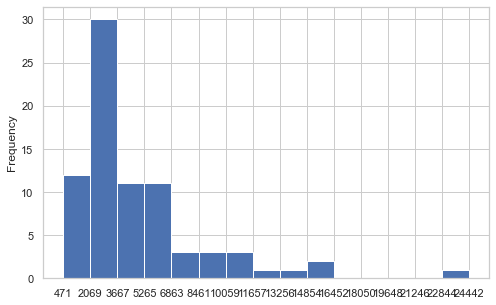

In [185]:
count, bin_edges = np.histogram(DenverCrimesSummary['Crimes'], 15)
DenverCrimesSummary['Crimes'].plot(kind='hist', figsize=(8, 5), bins = 15, xticks=bin_edges)

Map of the top 10 offenders for crime sake (the bigger circle the more crimes)

In [193]:
import math
map_crimes = folium.Map(location=[den_latitude, den_longitude], zoom_start=12)
for lat, lon, crimes, neigh in zip(DenverCrimesTop10['Latitude'], DenverCrimesTop10['Longitude'], DenverCrimesTop10['Crimes'], DenverCrimesSummary['Neighborhood']):
    label = folium.Popup(str(crimes) + ' - ' + neigh, parse_html=True)
    #neigh_list = sport_venues[sport_venues['Neighborhood'] == neigh].index.item()
    folium.CircleMarker(
        [lat, lon],
        radius=crimes/1000,
        popup=label,
        color='red',
        fill=True,
        #fill_color=rainbow[neigh_list],
        fill_opacity=0.7).add_to(map_crimes)

map_crimes

<h2>Demographic analysis</h2>

Demographic data last update 2010 from www.denvergov.org

In [187]:
denver_demo_url = 'https://www.denvergov.org/media/gis/DataCatalog/census_neighborhood_demographics_2010/csv/census_neighborhood_demographics_2010.csv'
denver_demo_dataset = pd.read_csv(denver_demo_url)
denver_demo_dataset.head()

,NBHD_ID,NBRHD_NAME,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,...,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,32,Hampden,17547.0,2505.0,11750.0,1963.0,64.0,726.0,20.0,38.0,...,1363.0,791.0,700.0,304.0,253.0,285.0,200.0,229.0,0.200466,0.000768
1,3,Baker,4879.0,1664.0,2854.0,144.0,43.0,52.0,10.0,7.0,...,486.0,235.0,231.0,113.0,64.0,82.0,23.0,7.0,0.101767,0.000406
2,70,Washington Park,6905.0,295.0,6356.0,28.0,9.0,119.0,3.0,13.0,...,329.0,132.0,70.0,31.0,36.0,27.0,6.0,21.0,0.090445,0.000411
3,13,Cherry Creek,5589.0,332.0,4896.0,79.0,17.0,168.0,4.0,3.0,...,521.0,261.0,211.0,79.0,92.0,161.0,224.0,207.0,0.063923,0.000228
4,22,Country Club,3001.0,94.0,2740.0,20.0,8.0,77.0,1.0,5.0,...,90.0,55.0,34.0,14.0,17.0,9.0,4.0,2.0,0.052865,0.000177


In [188]:
denver_demo_dataset.describe()

,NBHD_ID,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVEAM_2010,ASIAN_2010,HAWPACIS_2010,OTHER_2010,TWO_OR_MORE_2010,...,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,39.500000,7694.333333,2448.269231,4012.974359,748.564103,45.192308,255.448718,6.346154,15.487179,162.051282,...,570.141026,306.358974,232.666667,98.038462,78.102564,89.256410,57.435897,37.282051,0.098506,0.000539
std,22.660538,5166.830998,3039.875278,2814.578735,1476.224489,33.159613,278.218108,13.482867,11.967210,164.766966,...,573.003813,231.163515,169.866920,76.590231,61.972468,74.744662,56.443188,51.866687,0.076693,0.001305
min,1.000000,705.000000,62.000000,111.000000,20.000000,2.000000,20.000000,0.000000,0.000000,24.000000,...,6.000000,5.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.040371,0.000083
25%,20.250000,4213.000000,495.500000,1781.000000,89.500000,18.250000,77.250000,1.250000,6.000000,67.500000,...,213.500000,145.000000,117.250000,46.250000,36.000000,31.750000,17.250000,7.000000,0.061477,0.000210
50%,39.500000,6701.500000,1611.000000,3310.000000,237.000000,41.000000,146.500000,4.000000,13.000000,117.500000,...,422.500000,253.000000,180.000000,77.000000,58.000000,67.000000,36.500000,14.000000,0.082002,0.000305
75%,58.750000,9640.000000,2841.250000,5874.250000,726.750000,60.000000,396.000000,6.750000,20.000000,198.500000,...,665.750000,377.500000,295.750000,134.000000,99.250000,133.000000,84.000000,45.000000,0.110171,0.000411
max,78.000000,30348.000000,17855.000000,11750.000000,8605.000000,148.000000,1655.000000,110.000000,65.000000,1137.000000,...,3761.000000,1220.000000,896.000000,457.000000,347.000000,297.000000,246.000000,229.000000,0.632612,0.011454


Consider only the relevant columns: NBRHD_NAME, PCT_LESS_18, PCT_65_PLUS

In [189]:
Denver_demo = pd.DataFrame()
Denver_demo['Neighborhood'] = denver_demo_dataset['NBRHD_NAME']
Denver_demo['PCT_under18'] = denver_demo_dataset['PCT_LESS_18']
Denver_demo['PCT_over65'] = denver_demo_dataset['PCT_65_PLUS']
Denver_demo['PCT_18_65'] = 100 - denver_demo_dataset['PCT_LESS_18'] - denver_demo_dataset['PCT_65_PLUS']
Denver_demo.replace({'Stapleton':'Central Park'}, inplace=True) # To align the Neighborhood naming convention
Denver_demo.shape

(78, 4)

Distribution of PCT_18_65 on Histogram chart

<AxesSubplot:ylabel='Frequency'>

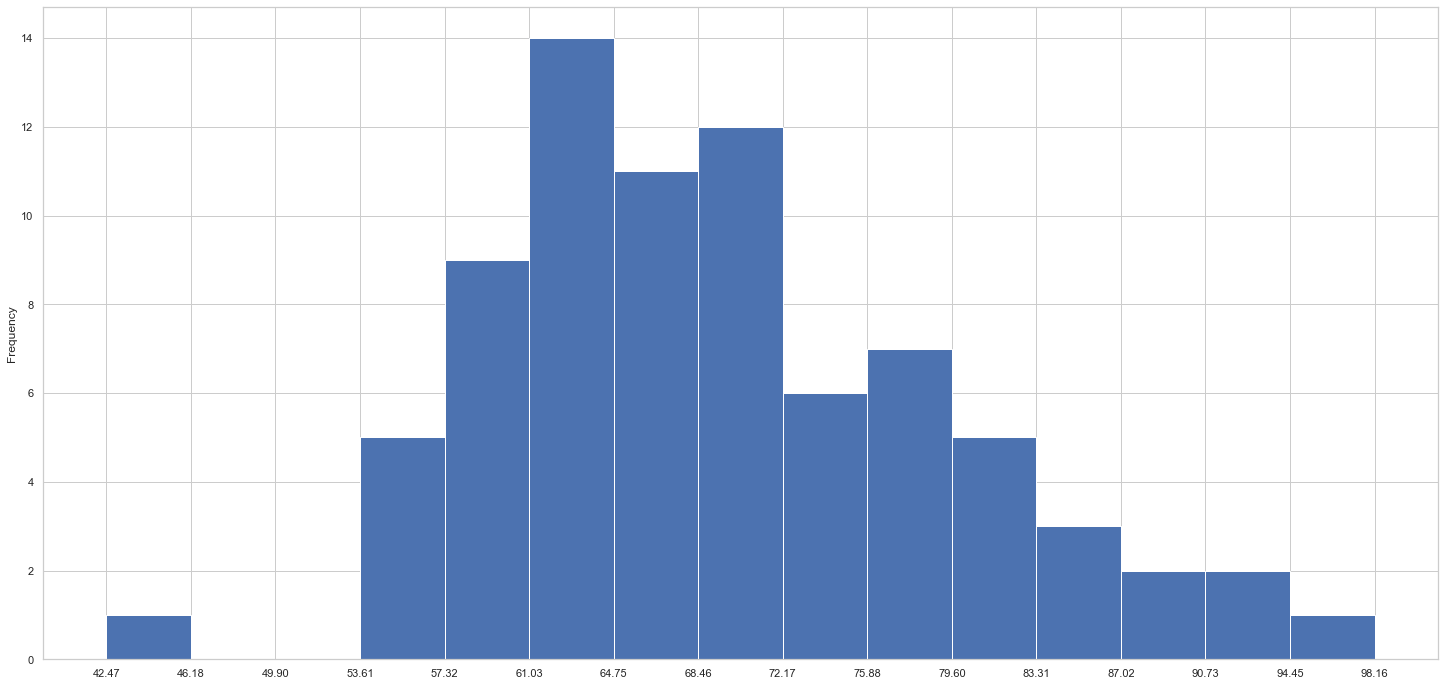

In [104]:
count, bin_edges = np.histogram(Denver_demo['PCT_18_65'], 15)
Denver_demo['PCT_18_65'].plot(kind='hist', figsize=(25, 12), bins = 15, xticks=bin_edges)

Top 10 Neighborhoods considering 18-65 population percentage

In [192]:
Temp1 = Denver_demo['Neighborhood'].str.replace(' ','')
Temp2 = Temp1.str.replace('/','')
Temp3 = Temp2.str.replace('-','')
Denver_demo['UnKey'] = Temp3.str.lower()
Denver_Neigh['UnKey'] = Denver_Neigh['Neighborhood'].str.replace(' ','')
DenverDemoSummary = Denver_Neigh.merge(Denver_demo, on='UnKey', how='inner')
DenverDemoSummary.drop(columns=['UnKey', 'Neighborhood_y'], inplace=True)
DenverDemoSummary.rename(columns={'Neighborhood_x':'Neighborhood'}, inplace=True)
Denver_18_65_Top10 = DenverDemoSummary.sort_values(by=['PCT_18_65'], ascending=False).head(10)
Denver_18_65_Top10.drop(columns=['PCT_under18','PCT_over65'], inplace=True)
Denver_18_65_Top10

,Neighborhood,Latitude,Longitude,PCT_18_65
1,auraria,39.746522,-105.006710,98.16
9,cbd,39.744719,-104.993992,91.72
8,capitol hill,39.735875,-104.979921,91.31
16,civic center,39.738181,-104.987744,90.42
47,north capitol hill,39.745624,-104.981598,89.41
63,university,39.675748,-104.966794,85.65
59,speer,39.719682,-104.979521,85.19
26,five points,39.754658,-104.977986,83.55
12,cheesman park,39.732814,-104.966455,81.66
70,washington park west,39.703126,-104.979274,80.62


Map of the top 10 neighborhood condidering PCT_18_65

In [194]:
map_demo = folium.Map(location=[den_latitude, den_longitude], zoom_start=12)
for lat, lon, pct_18_65, neigh in zip(Denver_18_65_Top10['Latitude'], Denver_18_65_Top10['Longitude'], Denver_18_65_Top10['PCT_18_65'], Denver_18_65_Top10['Neighborhood']):
    label = folium.Popup(str(pct_18_65) + ' - ' + neigh, parse_html=True)
    #neigh_list = sport_venues[sport_venues['Neighborhood'] == neigh].index.item()
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='yellow',
        fill=True,
        #fill_color=rainbow[neigh_list],
        fill_opacity=0.7).add_to(map_demo)

map_demo

<h2>Conclusion</h2>

Let's finally connect the dots and summarize the outcome of our analysis and deliver final considerations.

After the clustering analysis we identified two macro-areas for CF box location.
<ul>
    <li> Cluster <b>2</b>: athmar park, bear valley, chaffee park, college view south platte, hampden south, rosedale, speer, university park</li>
    <li> Cluster <b>4</b>: baker, barnum, barnum west, belcaro, capitol hill, central park, cheesman park, city park, city park west, clayton, cole, congress park, country club, dia, east colfax, five points, fort logan, globeville, hale, hampden, hilltop, kennedy, lincoln park, mar lee, motbello,north park hill, overland, platt park, regis, skyland, sloan lake, southmoor park, sunnyside, university, villa park, washington park west, washington virginia vale, west colfax, west highland, westwood, whittier
</ul>

Using the crimes dataset we identified 10 neighborhoods <b>better to avoid</b>.
<ul>
    <li>five points</li>
    <li>cbd</li>
    <li>capitol hill</li>
    <li>montbello</li>
    <li>east colfax</li>
    <li>civic center</li>
    <li>union station</li>
    <li>lincoln park</li>
    <li>westwood</li>
    <li>gateway green valley ranch</li>
</ul>

Finally from the demographic 2010 dataset we have identified the top 10 neighborhoods for citizen age between 18 and 65 <b>to consider</b>.
<ul>
    <li>auraria</li>
    <li>cbd</li>
    <li>capitol hill</li>
    <li>civic center</li>
    <li>north capitol hill</li>
    <li>university</li>
    <li>speer</li>
    <li>five points</li>
    <li>cheesman park</li>
    <li>washington park west</li>
</ul>
    

The Denver neighboorhoods meeting all the above criteria are the following:
<p>
<ul>
<li><b>university</b></li>
<li><b>speer</b></li>
<li><b>cheesman park</b></li>
<li><b>washington park west</b></li>
</ul>

On the city map

In [196]:
FinalNeighList = ['university', 'speer', 'cheesman park', 'washington park west']
map_final = folium.Map(location=[den_latitude, den_longitude], zoom_start=12)
for lat, lon, pct_18_65, neigh in zip(Denver_18_65_Top10['Latitude'], Denver_18_65_Top10['Longitude'], Denver_18_65_Top10['PCT_18_65'], Denver_18_65_Top10['Neighborhood']):
    if neigh in FinalNeighList:
        label = folium.Popup(str(pct_18_65) + ' - ' + neigh, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=10,
            popup=label,
            color='green',
            fill=True,
            #fill_color=rainbow[neigh_list],
            fill_opacity=0.7).add_to(map_final)

map_final